-------
<h1 align="center"> <font size="30"> CS5785 HW 1 -- Applied Machine Learning </font>  </h1>  

-------

<h1 align="center"> <font size="5"> Student: Shangjing Tang(st787)， Katherine Wu(Kw634) </font> </h1>  
&nbsp;
&NewLine;
&NewLine;

<h1 align="center"> <font size="5"> Due Date: September 13th </font> </h1> 


<div style="page-break-after: always; break-after: page;"></div>
<h1 align="center"> <font size="5"> PROGRAMMING EXERCISES </font> </h1>

#### Part I. The Housing Prices
1. Join the House Prices - Advanced Regression Techniques competition on Kaggle. Download the training and test data.
2. Give3 examples of continuous and categorical features in the dataset; choose one feature of each type and plot the histogram to illustrate the distribution.

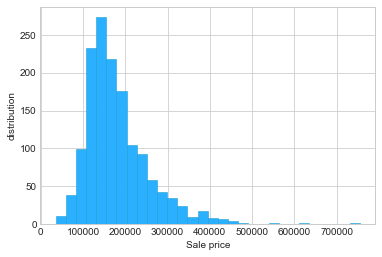

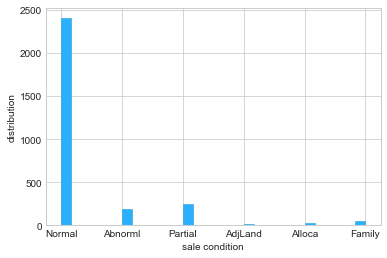

In [455]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import warnings
import seaborn as sns
from scipy.stats import skew
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
%matplotlib inline
workingDirectory = os.getcwd()
trainData = pd.read_csv(workingDirectory+"/train.csv")
testData = pd.read_csv(workingDirectory+ "/test.csv")
all_data = pd.concat([trainData, testData], axis=0) #merge both trainig

con_feat1  = all_data['SalePrice']
con_feat2 = all_data['LotFrontage'] 
con_feat3 = all_data['LotArea']

cat_feat4 = all_data['SaleCondition']
cat_feat5 = all_data['MSZoning']
cat_feat6 = all_data['LotShape']

plt.style.use('seaborn-whitegrid')
plt.hist(con_feat1, bins=30,facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)  # density=False would make counts
plt.ylabel('distribution')
plt.xlabel('Sale price')

plt.show()

plt.style.use('seaborn-whitegrid')
plt.hist(cat_feat4, bins=30,facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)  # density=False would make counts
plt.ylabel('distribution')
plt.xlabel('sale condition')

plt.show()





<span style="color:blue">Answer: The distribution for continuous feature in the graph is the sale price from training dataset. This feature has a left skewed histogram. Each bar in the histogram represents how many occurance in each price range. The second graph has the categorical data of "sales condition". In this graph the data has 6 different categories and the heigh of the bar represents the number of occurence of each category.</span>

2. Pre-process your data, explain your pre-processing steps, and the reasons why you need them. (Hint: data pre-processing steps can include but are not restricted to: dealing with missing values, normalizing numerical values, dealing with categorical values etc.)

<span style="color:blue"> 
In this pre-processing stage, we mainly perform 4 steps.
<span style="color:blue"> 
    
* Drop columns where they have greater than 75% of NA values. When we perform data cleaning process, we found that there are several columns such as "Alley" has mainly NA values which are not significant to our study.

* For remaining columns that don't have greater than 75% of NA values but do have small amount of NA values in the column. We will then fill mean values for those numeric features who has NA, and mode for those categorical values who has NA. Check if there is any additional NA values in the data set
 
* We then divided dataset into categorical features and continuous features. Also manually exclude some categorical features who has numeric values from the continuous feature sets and extend those numeric categorical feature into the categorical feature sets.

* Finally, we will check for the skewness of the continuous features. When we plot the histogram for "Sale price". We found that the graph is left skewed, which may mean there are a bunch of outliers in the dataset. So we take a log function to normalize those feature.


In [456]:
#drop columns with NA values greater than 75%
all_data1 = all_data.dropna(axis='columns', thresh=0.25*len(all_data))
saleprice = all_data1['SalePrice']

In [457]:
#fill the remaining data with mean in numerical, mode in categorical: https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas
all_data1.fillna(all_data1.agg(['mean',lambda x : x.value_counts().index[0]]).ffill().iloc[-1,:],inplace = True)

#check if there are still na in the data set 
def find_nan_cols(data):
    cols = []
    lenn = len(data)
    for col in data.columns:
        if (data[col].count() < lenn):
            cols.append(col)
    return cols
len(find_nan_cols(all_data1))==0

True

In [458]:
# distinguish data between categorical and continuous
col_numeric = list(all_data1.select_dtypes(exclude = 'object').columns)

for cols in ['OverallCond','OverallQual','YearRemodAdd','YearBuilt','YrSold','MoSold','MSSubClass']:
    col_numeric.remove(cols)
    
col_category= list(all_data1.select_dtypes(include = 'object').columns)
all_data1[col_numeric].head(30)
col_category.extend(['OverallCond','OverallQual','YearRemodAdd','YearBuilt','YrSold','MoSold','MSSubClass'])
all_num = all_data1[col_numeric]
all_cat = all_data1[col_category]
all_num = all_num.drop('SalePrice',axis=1)

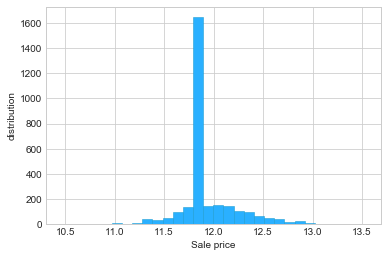

In [459]:
#Check skewness of dependent variable and independent variables, take log to normalize data
skews = all_num.apply(lambda x: skew(x))
skews = skewness[abs(skews) > 0.5]
skewed_feat = skews.index
all_num[skewed_feat] = np.log1p(all_num[skewed_feat])
all_data1.SalePrice = np.log1p(all_data1.SalePrice)

plt.style.use('seaborn-whitegrid')
plt.hist(all_data1['SalePrice'], bins=30,facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)  # density=False would make counts
plt.ylabel('distribution')
plt.xlabel('Sale price')
plt.show()

In [460]:
all_data1['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1454    11.849405
1455    11.849405
1456    11.849405
1457    11.849405
1458    11.849405
Name: SalePrice, Length: 2919, dtype: float64

4. One common method of pre-processing categorical features is to use a one-hot encoding (OHE).
Suppose that we start with a categorical feature xj , taking three possible values: xj ∈ {R , G , B }. A one-hot encoding of this feature replaces xj with three new features: xjR,xjG,xjB. Each feature contains a binary value of 0 or 1, depending on the value taken by xj . For example, if xj = G , then xjG =1 and xjR =xjB =0.

    Give some examples of features that you think should use a one-hot encoding and explain why. Convert at least one  feature to a one-hot encoding (you can use your own implementation, or that in pandas or scikit-learn) and visualize the results by plotting feature histograms of the original feature and its new one-hot encoding.

<span style="color:blue">Answer:The features that can be using one-hot encoding are 'LotShape', 'Sales Conditions", 'LotConfig', and 'MSZoning', etc. In this example, I will pick all categorical features to perform the one-hot encoding.

In [461]:
#Check unique features within each variable
for col in all_data1[col_category].columns:
    print(col,':',len(all_data1[col_category][col].unique()),'label')

MSZoning : 5 label
Street : 2 label
LotShape : 4 label
LandContour : 4 label
Utilities : 2 label
LotConfig : 5 label
LandSlope : 3 label
Neighborhood : 25 label
Condition1 : 9 label
Condition2 : 8 label
BldgType : 5 label
HouseStyle : 8 label
RoofStyle : 6 label
RoofMatl : 8 label
Exterior1st : 15 label
Exterior2nd : 16 label
MasVnrType : 4 label
ExterQual : 4 label
ExterCond : 5 label
Foundation : 6 label
BsmtQual : 4 label
BsmtCond : 4 label
BsmtExposure : 4 label
BsmtFinType1 : 6 label
BsmtFinType2 : 6 label
Heating : 6 label
HeatingQC : 5 label
CentralAir : 2 label
Electrical : 5 label
KitchenQual : 4 label
Functional : 7 label
FireplaceQu : 5 label
GarageType : 6 label
GarageFinish : 3 label
GarageQual : 5 label
GarageCond : 5 label
PavedDrive : 3 label
SaleType : 9 label
SaleCondition : 6 label
OverallCond : 9 label
OverallQual : 10 label
YearRemodAdd : 61 label
YearBuilt : 118 label
YrSold : 5 label
MoSold : 12 label
MSSubClass : 16 label


In [462]:
#Lotshape_feat = all_data1[col_category]['LotShape']
all_cat = pd.get_dummies(all_cat.astype(str), drop_first = True) #one hot encoding using panda methods without the sale price
all_cat.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


5. Using ordinary least squares(OLS),try to predict house prices on this dataset.Choose the features (or combinations of features) you would like to use or ignore, provided you justify your choice. Evaluate your predictions on the training set using the MSE and the R2 score. For this question, you need to implement OLS from scratch without using any external libraries or packages.


In [463]:
# join both numeric and catgorical data without sale price
join_data = pd.concat([all_num,all_cat],axis=1)
#training_d = join_data.iloc 
train_row = trainData.shape[0]#return row number
training = join_data.iloc[:train_row] # we only want cleanned data with the original training data size
x_test = join_data.iloc[train_row:]
y = all_data1[:train_row].SalePrice
x_train, x_valid,y_train,y_valid = train_test_split(training, y, test_size = 0.3, random_state = 0)


<span style="color:blue"> Based on the course lecture, for any parameter vector $\theta$, the fitted value is X$\theta$, and thus the term in the exponent is the function showing as below:

<span style="color:blue">
$$
S(\theta) = (y-X\theta)^\top * (y-X\theta)
$$

<span style="color:blue">
This function is a measure of goodness of fit. If S$\theta$ is small, then y and the fiited value will be caloses located to yield a smaller MSE. The minimum value of S($\theta$) is obtained when 
            $$X^\top X\theta = X^\top y $$

<span style="color:blue">
Therefore we can get the OLS equation of $$ \theta^* = (X^\top X)^{-1} X^\top y.$$

In [464]:
#define the theta function.   
def theta(x_train, y_train):
    return np.linalg.pinv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train) 

<span style="color:blue">
$$ f(x) = \theta^\top X $$
Since the x_train matrix is a singular square matrix that cannot be inverted, we compute the pseudo-inverse of the matrix. Once we have the theta value, we can then calculate the MSE.

In [465]:
theta1 = theta(x_train, y_train)
mse = mean_squared_error(x_valid.dot(theta1),y_valid)
r2 = r2_score(x_valid.dot(theta1), y_valid)
theta2 = theta(x_train, y_train).reshape((454,1))
y_pred = x_train.dot(theta2)

In [466]:
mse, r2

(0.11466877348676957, 0.5362345578749224)

6. Train your model using all of the training data (all data points,but not necessarily all the features), and test it using the testing data. Submit your results to Kaggle.

In [467]:
y_pred_test = x_test.dot(theta(x_train, y_train))
y_pred_test = np.expm1(y_pred_test)

In [468]:
y_pred_test

0       131764.329268
1       158689.308818
2       193009.441106
3       201673.866413
4       182524.631302
            ...      
1454     86250.612875
1455     64654.611393
1456    165958.051713
1457    111546.692319
1458    185505.593657
Length: 1459, dtype: float64

In [469]:
submission = testData.copy()

submission["SalePrice"] = y_pred_test
submission = submission[["Id", "SalePrice"]]
submission.to_csv('./submission.csv',index=False)

In [470]:
submission

,Id,SalePrice
0,1461,131764.329268
1,1462,158689.308818
2,1463,193009.441106
3,1464,201673.866413
4,1465,182524.631302
...,...,...
1454,2915,86250.612875
1455,2916,64654.611393
1456,2917,165958.051713
1457,2918,111546.692319


<span style="color:blue"> Below is our submission score in Kaggle. Our overall score is 0.62918     
 <img src="submitKaggle2.jpeg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
Since our pitures don't show when convert Jupyter HTML to PDF, we will include both pictures of Kaggle scores in the last page of the pdf file. 

In [1]:
print((1/5)*e**(-0.2*10))

NameError: name 'e' is not defined